# 2 - Análise Exploratória da Base de Dados

Concluída a fase de limpeza da base de dados, procedemos à fase de análise exploratória.

Nessa fase, buscaremos conhecer mais de perto da base de dados. Buscaremos padrões e relacionamentos interessantes entre os campos.

In [1]:
# para carregar a base de dadas limpa
import pickle

import numpy as np
import pandas as pd
from scipy import stats as spst
from tqdm import tqdm

# gráficos
import seaborn as sns
from matplotlib import rcParams, pyplot as plt

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import scripts.plots as splt, scripts.metrics as smetrics
os.chdir(cwd)

# parâmetros do matplotlib
# essencialmente, para deixar os gráficos maiores por padrão
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = (10, 8)

## Importação e checagem de integridade

Vamos importar os dados limpos e verificar a integridade dos mesmos.

In [2]:
with open(r'../data/covid_limpo.df', 'rb') as covidfile:
    pickler = pickle.Unpickler(file = covidfile)
    covid = pickler.load()

In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495062 entries, 0 to 499691
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   sex                  495062 non-null  category
 1   patient_type         495062 non-null  category
 2   pneumonia            495062 non-null  category
 3   age                  495062 non-null  int8    
 4   pregnancy            495062 non-null  category
 5   diabetes             495062 non-null  category
 6   copd                 495062 non-null  category
 7   asthma               495062 non-null  category
 8   inmsupr              495062 non-null  category
 9   hypertension         495062 non-null  category
 10  other_disease        495062 non-null  category
 11  cardiovascular       495062 non-null  category
 12  obesity              495062 non-null  category
 13  renal_chronic        495062 non-null  category
 14  tobacco              495062 non-null  category
 15  

In [4]:
covid.head()

,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res
id,,,,,,,,,,,,,,,,,
0,0,1,0,27,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,24,0,0,0,0,0,0,0,0,0,0,0,NaN,1
2,1,0,0,54,0,0,0,0,0,0,0,0,1,0,0,NaN,1
3,0,0,1,30,0,0,0,0,0,0,0,0,0,0,0,NaN,1
4,1,0,0,60,0,1,0,0,0,1,0,1,0,0,0,NaN,1


Parece que está tudo como deveria ser.

## Análise de estatísticas descritivas do conjunto de dados

Nesta seção analisaremos as estatísticas descritivas dos dados, com o objetivo de detectar potenciais relacionamentos e/ou inconsistências.

In [5]:
covid.covid_res.value_counts(normalize = True)

0    0.559096
1    0.440904
Name: covid_res, dtype: float64

A variável dependente (`covid_res`) é razoavelmente balanceada, o que vai facilitar bastante nossa análise.

Vamos inicialmente fazer uma análise mais abrangente, com todas as variáveis disponíveis na base de dados.

In [6]:
covid.describe()

,age
count,495062.000000
mean,42.516004
std,16.624198
min,0.000000
25%,31.000000
50%,41.000000
75%,53.000000
max,120.000000


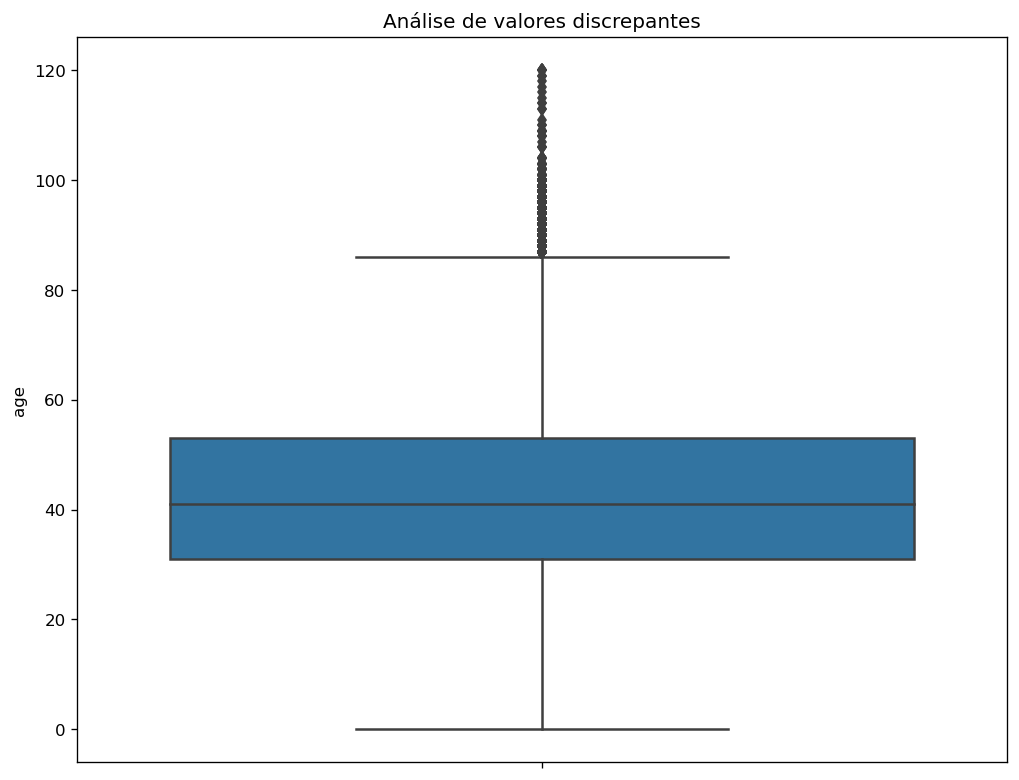

In [7]:
ax = sns.boxplot(data = covid, y = 'age')
ax.set_title('Análise de valores discrepantes')
plt.show()

Há vários valores fora do intervalo interquartil (*IQR*). Vamos separar só por idade:

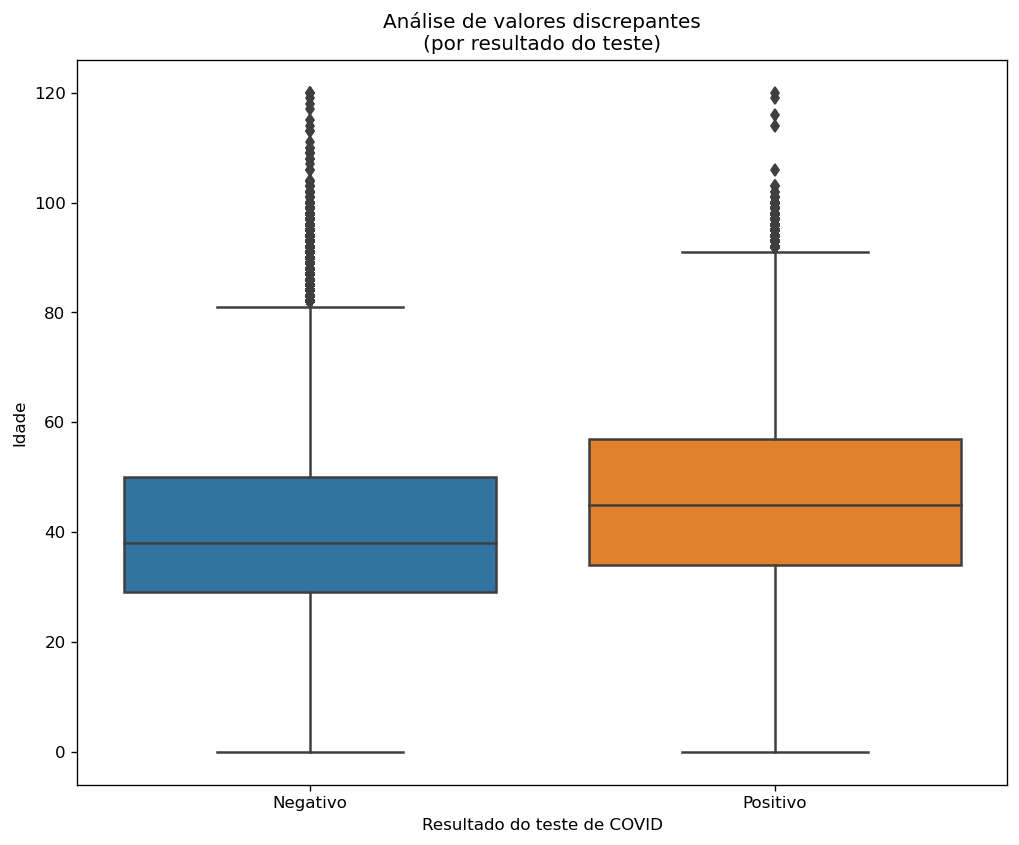

In [8]:
ax = sns.boxplot(data = covid, y = 'age', x = 'covid_res')

ax.set_title('Análise de valores discrepantes\n(por resultado do teste)')

ax.set_ylabel('Idade')
ax.set_xlabel('Resultado do teste de COVID')
ax.set_xticklabels(['Negativo', 'Positivo'])

plt.show()

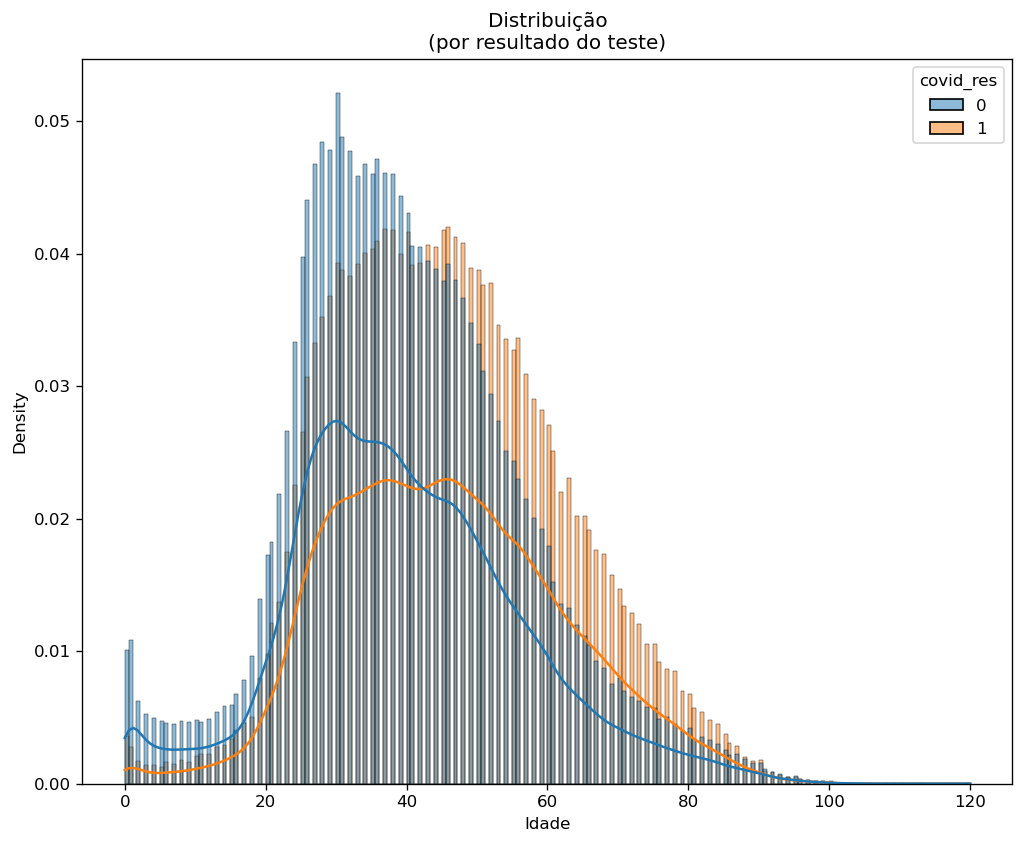

In [9]:
ax = sns.histplot(data = covid, x = 'age', hue = 'covid_res', stat = 'density', common_norm = False, kde = True, multiple = 'layer')

ax.set_title('Distribuição\n(por resultado do teste)')

ax.set_xlabel('Idade')

# handles, labels = ax.get_legend_handles_labels()
# labels = ['Negativo', 'Positivo']
# ax.legend(title = 'Resultado do teste', labels = labels, handles = handles)

plt.show()

Dos gráficos acima, conclui-se que

* a idade é uma *feature* útil para separar de forma preditiva os pacientes que testaram positivo e negativo para COVID; e
* no conjunto de dados há muitas crianças sendo testadas, a maioria com resultado negativo. Posteriormente, exploraremos a possibilidade de modelarmos o resultado do teste para crianças separadamente.

In [10]:
e_crianca = (covid.age <= 10)
e_idoso = (covid.age >= 60) & (covid.age < 80)
e_muito_idoso = (covid.age >= 80)
e_adulto = (~e_crianca) & (~e_idoso) & (~e_muito_idoso)

### Status de internação

É razoável supor que, se o paciente for internado, isso se deve a ele ter apresentado sintomas na chegada ao local de teste.

Vamos então separar por status de internação e resultado do teste, de forma a ter uma visão mais ampla:

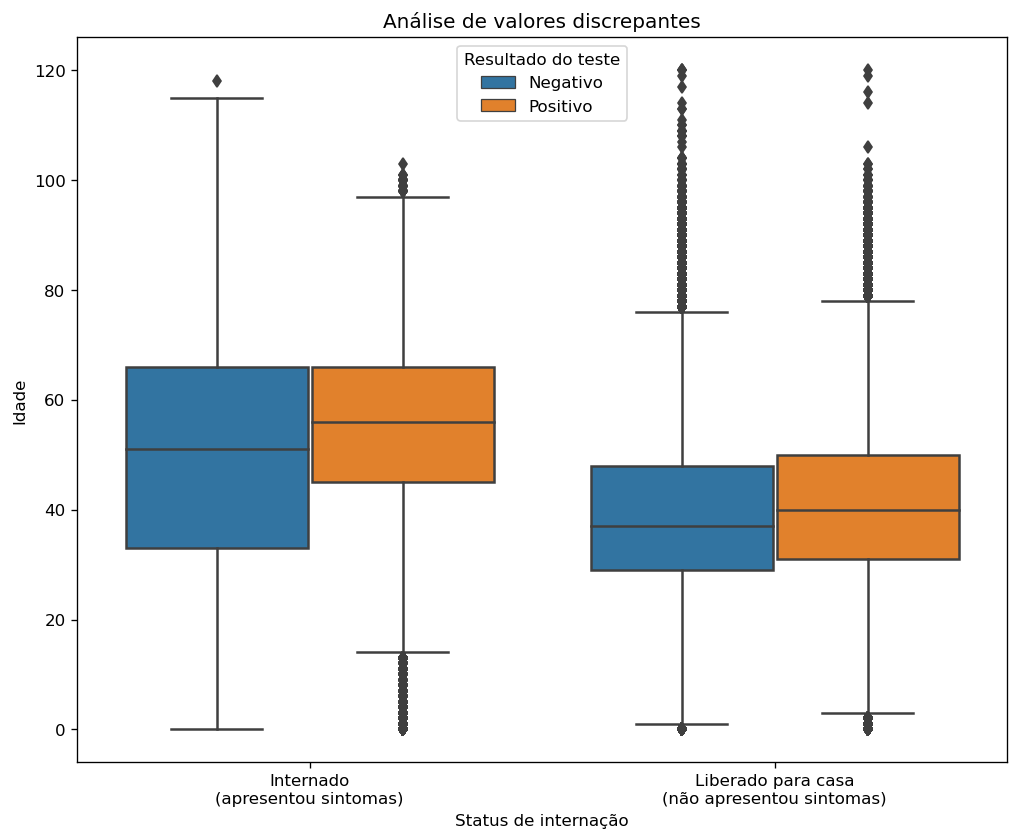

In [11]:
tem_sintomas = (covid.patient_type == 0)  # paciente internado, inferimos que apresentou sintomas. caso tenham sido
                                          # dispensados para casa, podem ter apresentado sintomas, mas eram leves
teste_positivo = (covid.covid_res == 1)

ax = sns.boxplot(data = covid, y = 'age', x = 'patient_type', hue = 'covid_res')

ax.set_title('Análise de valores discrepantes')
ax.set_ylabel('Idade')
ax.set_xlabel('Status de internação')
ax.set_xticklabels(['Internado\n(apresentou sintomas)', 'Liberado para casa\n(não apresentou sintomas)'])

handles, labels = ax.get_legend_handles_labels()
labels = ['Negativo', 'Positivo']
ax.legend(title = 'Resultado do teste', labels = labels, handles = handles, loc = 'upper center')
plt.show()

Sabemos por conhecimento de domínio que grande parte dos acometidos por COVID que apresentam algum tipo de sintoma tem idade mais avançada. Isso é confirmado pelo gráfico acima: dentre os pacientes que foram internados (ou seja, que apresentaram sintomas mais graves), a distribuição dos acometidos por COVID é mais concentrada ao redor de uma média superior à da distribuição dos não acometidos por COVID.

Os *outliers* inferiores são devido ao excesso de crianças sendo testadas, como vimos acima. Vamos ver a distribuição dos pacientes que foram liberados para casa, de forma a investigar os *outliers* superiores:

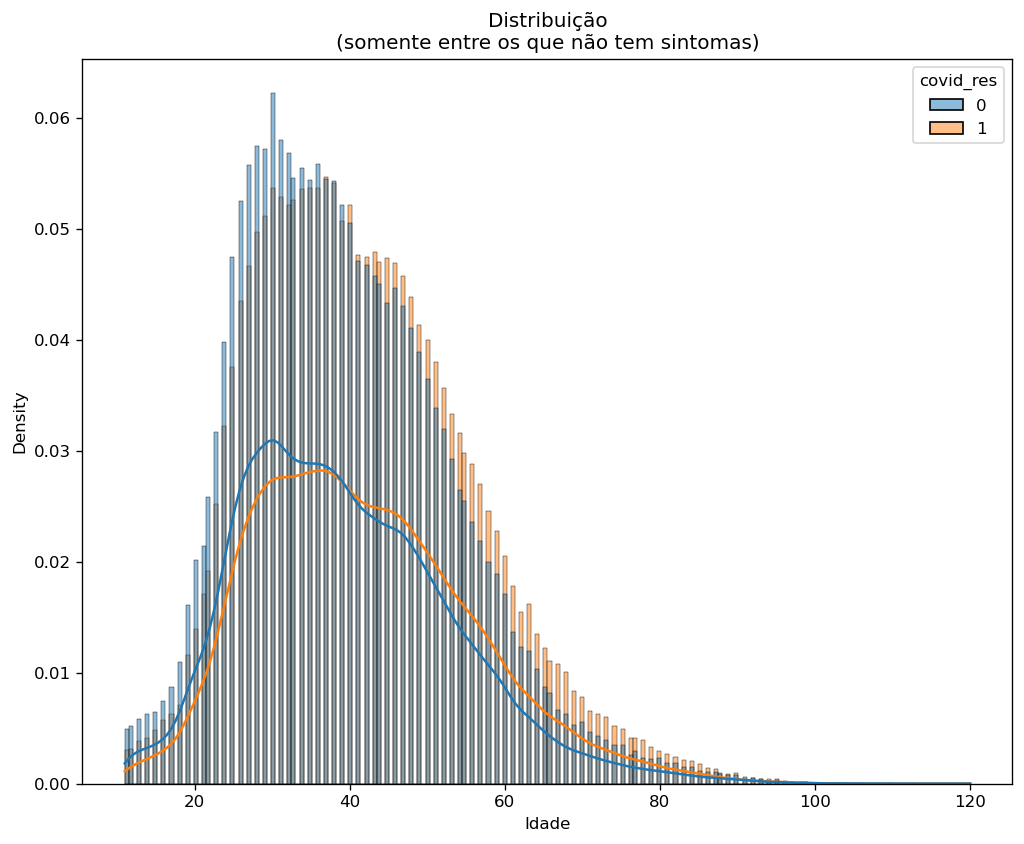

In [12]:
ax = sns.histplot(data = covid[(~tem_sintomas) & (~e_crianca)], x = 'age', hue = 'covid_res', stat = 'density', common_norm = False, kde = True, multiple = 'layer')

ax.set_title('Distribuição\n(somente entre os que não tem sintomas)')

ax.set_xlabel('Idade')

# handles, labels = ax.get_legend_handles_labels()
# labels = ['Negativo', 'Positivo']
# ax.legend(title = 'Resultado do teste', labels = labels, handles = handles)

plt.show()

Apesar de o *boxplot* indicar a presença de *outliers* com idades superiores, o histograma não revela comportamentos muito estranhos, exceto o do excesso de crianças sendo testadas.

Além disso, os gráficos nos dizem que a idade não é muito relevante para prever um resultado de teste positivo ou negativo se o paciente tiver sido liberado para casa.

#### Relação entre *status* de internação e comorbidades aparentes

Vamos quantificar a relação entre o paciente apresentar comorbidades aparentes e a liberação ou internação dele.

In [13]:
# filtro para paciente tem alguma comorbidade que seria aparente após uma anamnese básica

comorbs_aparentes = [ 'pneumonia', 'diabetes', 'copd', 'asthma', 'hypertension', 'obesity', 'tobacco' ]

filtro = pd.Series(False, index = covid.index)

for c in comorbs_aparentes:
    filtro = filtro | (covid[c] == 1)

filtro = filtro.map({True: 1, False: 0})

cmb_dict = {
    'patient_type': covid['patient_type'],
    'comorbs_aparentes': filtro
}
cmb_df = pd.DataFrame(cmb_dict)

In [14]:
# teste de significancia: colunas são relacionadas?

alpha = 0.05

contingencia = pd.crosstab(*[ cmb_df[c] for c in cmb_df])

chisq_crit, pvalor, a, b = spst.chi2_contingency(contingencia)

print('Colunas são relacionadas? ', end = '')

if pvalor < alpha:
    print('Sim. ', end = '')
    sinal = '<'

else:
    print('Não. ', end = '')
    sinal = '>='

print(f"(p-valor {pvalor:.3%} {sinal} alfa = {alpha:.1%})")

Colunas são relacionadas? Sim. (p-valor 0.000% < alfa = 5.0%)


In [15]:
# quantificação da relação entre as colunas: Cràmer V
from sklearn.metrics import v_measure_score

v = v_measure_score(
    labels_true = cmb_df['patient_type'],
    labels_pred = cmb_df['comorbs_aparentes']
)

print('Cràmer-V vai de 0 (perfeitamente descorrelacionadas) até 1 (perfeitamente correlacionadas).')
print(f"Estatística 'Cràmer-V' entre status de liberação e presença de comorbidades aparentes: {v:.2%}")

Cràmer-V vai de 0 (perfeitamente descorrelacionadas) até 1 (perfeitamente correlacionadas).
Estatística 'Cràmer-V' entre status de liberação e presença de comorbidades aparentes: 12.42%


Vemos portanto que há no processo decisório de liberar ou internar o paciente algo muito além das comorbidades aparentes.

### Comorbidades

Vamos agora analisar como a presença de comorbidades afeta o resultado do teste.

Inicialmente, veremos se a presença de qualquer comorbidade tem efeito sobre o resultado do teste.

Vamos definir algumas funções para facilitar nossa vida ao calcularmos as estatísticas e plotarmos os gráficos

In [16]:
from typing import Iterable

# função para construir uma tabela de contingência 
# da coluna 'col' e a coluna do resultado do teste de COVID
# e realizar um teste qui-quadrado para verificar se as colunas são relacionadas

def calc_pvalor_quiquad(
    data: pd.DataFrame, 
    col: str or list
) -> float:
    if isinstance(col, str):
        col1 = data[col]
        col2 = data['covid_res']
    
    else:  # assume-se que, se 'col' não for string, é um iteravel (similar a lista)
        col1 = data[col[0]]
        col2 = data[col[1]]
    
    cont = pd.crosstab(col1, col2)

    p_valor = spst.chi2_contingency(cont)[1]

    return p_valor

# função para, dado um d e uma lista de comorbidades, construir uma serie relacionando a comorbidade
# ao p-valor do teste qui-quadrado da tabela de contingencia entre a comorbidade e o resultado do
# teste de COVID

def calc_relacao_comorbs(
    data: pd.DataFrame, 
    cols: Iterable  
) -> pd.Series:
    
    calc_pvalor_vectorized = np.vectorize(lambda col: calc_pvalor_quiquad(data = data, col = col))

    cols_idx = pd.Index(cols, name = 'comorb')
    pvalores = pd.Series(
        calc_pvalor_vectorized(cols_idx),
        name = 'pvalor', 
        index = cols_idx
    )
    return pvalores

# correção do nível de significancia para multiplas comparações
def correcao_alpha_multiplas(alpha: float, ncomps: int) -> float:
    # correção de bonferroni
    # outras correções podem ser implementadas aqui
    return alpha / ncomps

In [17]:
# função para plotar um boxplot da idade separando por categorias

def plot_box_comorbs(
    conf_dict: dict, 
    data_df: pd.DataFrame, 
    nome_filtro: str or None = None, 
    eixox: str = 'comorb'
) -> plt.Figure:
    # eixo = ('comorb', 'res')

    fig, axs = plt.subplots(ncols = len(conf_dict.keys()), sharex = True, sharey = True)

    # loop pelas comorbidades
    for i, (tipo, tipo_dict) in enumerate(conf_dict.items()):

        ax = axs[i]

        nome_comorb = tipo_dict['nome']

        # desenhar o boxplot
        if eixox == 'comorb':
            sns.boxplot(data = data_df, 
                y = 'age', x = nome_comorb, 
                hue = 'covid_res',
                ax = ax,
                palette = sns.color_palette(None),
            )
        
        else:
            sns.boxplot(data = data_df, 
                y = 'age', hue = nome_comorb, 
                x = 'covid_res',
                ax = ax,
                palette = sns.color_palette('Set2'),
            )
        
        # deixar o gráfico mais bonito
        comorb_titulo = f"... {nome_comorb}"
        fracao = data_df[nome_comorb].sum() / data_df[nome_comorb].shape[0]
        comorb_titulo += f'\n({fracao:.1%} do total)'
        ax.set_title(comorb_titulo)

        if i == 0:
            ax.set_ylabel('Idade')
        else:
            ax.set_ylabel('')

        if eixox == 'comorb':
            ax.set_xlabel(f"Tem comorbidade?")
            ax.set_xticklabels(['Não', 'Sim'])

        else:
            ax.set_xlabel(f"Resultado do teste")
            ax.set_xticklabels(['Negativo', 'Positivo'])
        
        ax.get_legend().remove()
    
    # titulo do grafico
    suptitle = 'Análise de valores discrepantes (comorbidades e idade)'
    
    if nome_filtro is not None:
        suptitle += f'\n(filtro: {nome_filtro})'

    suptitle += '\nProblemas de ...'

    plt.suptitle(suptitle)
    
    # acertar dimensoes do gráfico para todos os elementos aparecerem e não ficar muito espaço em branco
    plt.tight_layout()
    
    legend_kwargs = dict(
        bbox_to_anchor = (1.05, 1.19),
        frameon = False
    )
    if eixox == 'comorb':
        handles, labels = ax.get_legend_handles_labels()
        labels = ['Negativo', 'Positivo']
        plt.legend(title = 'Resultado do teste', labels = labels, handles = handles, **legend_kwargs)

    else:            
        handles, labels = ax.get_legend_handles_labels()
        labels = ['Não', 'Sim']
        plt.legend(title = 'Tem comorbidade?', labels = labels, handles = handles, **legend_kwargs)
    
    plt.show()

    return fig

figs = {}

In [18]:
from typing import Iterable

# plot do heatmap com a tabela de contingencia, % da margem vertical (tem/não tem comorbidade)

def plot_heatmap_contingencia(
    df: pd.DataFrame, 
    comorbidades: Iterable,
    fmt: str = '.1%',
    mapa_comorb: dict or None = None,
    mapa_res: dict or None = None,
    fig_kwds: dict = dict(),
    teste_quiquad: bool = False,
    filtro: str or None = None,
    cmap_lims: list = [0, 1]
) -> plt.Figure:

    if mapa_comorb is None:
        mapa_comorb = {
            False: 'Não',
            True: 'Sim',
            0: 'Não',
            1: 'Sim'
        }

    if mapa_res is None:
        mapa_res = {
            0: 'Negativo',
            1: 'Positivo'
        }

    contingencias = {}

    df = df.copy()
    col2 = df['covid_res'].map(mapa_res)

    for comorbidade in comorbidades:

        col1 = df[comorbidade].map(mapa_comorb)

        # tabela de contingencia com comorbidades nas linhas(tem;não tem) e resultado do teste 0/1 em duas colunas
        
        contingencia = pd.crosstab(col1, col2)  
        contingencias[comorbidade] = contingencia


    # figura
    nplots = len(comorbidades) 
    fig, axs = plt.subplots(nrows = nplots, **fig_kwds, sharex = True)

    for i, (comorbidade, contingencia) in enumerate(contingencias.items()):
        
        if nplots > 1:
            ax = axs[i]
        else:
            ax = axs
        
        # normalizar pelas linhas: o % plotado é a célula dividido pelo total de pessoas que tem/não tem a comorbidade
        contingencia_pct = contingencia.apply(lambda col: col / contingencia.sum(axis = 1))
        
        # plotar heatmap
        sns.heatmap(
            contingencia_pct, 
            annot = True, fmt = fmt, 
            cmap = 'viridis', vmax = cmap_lims[1], vmin = cmap_lims[0],
            ax = ax
        )

        # colorbar
        cbar = ax.collections[-1].colorbar
        cbar.ax.yaxis.set_major_formatter(lambda y, pos: f'{y:{fmt}}')

        # eixo x: resultado
        ax.set_xlabel('Resultado do teste de COVID')

        # eixo y
        ylabel = ax.get_ylabel()
        newylabel = f"Tem comorbidade: '{comorbidade}'?"
        ax.set_ylabel(newylabel)

        # titulo de cada subgrafico
        axtitle = f"Comorbidade '{comorbidade}'"
        if teste_quiquad:
            pvalor = spst.chi2_contingency(contingencia)[1]
            axtitle += f"\n(p-valor teste $\chi ^2$ = {pvalor:.2%})"

        ax.set_title(axtitle)

    # titulo do gráfico
    suptitle = 'Tabelas de contingência: % do total de comorbidades, margem vertical'
    if filtro is not None:
        suptitle += f'\n(filtro: {filtro})'
    plt.suptitle(suptitle)

    plt.tight_layout()
    plt.show()

    return fig

Definidas as funções vamos primeiramente calcular as estatísticas relevantes.

Primeiramente, vamos calcular as frequências de ocorrência de cada

In [19]:
covid.columns

Index(['sex', 'patient_type', 'pneumonia', 'age', 'pregnancy', 'diabetes',
       'copd', 'asthma', 'inmsupr', 'hypertension', 'other_disease',
       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco',
       'contact_other_covid', 'covid_res'],
      dtype='object')

In [20]:
todas_comorbs = ['pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr', 
    'hypertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco'
]

comorbs_freqs = pd.DataFrame([], columns = todas_comorbs)

for comorb in comorbs_freqs:
    comorbs_freqs[comorb] = covid[comorb].value_counts(normalize = True)

comorbs_freqs = comorbs_freqs.transpose().sort_values(by = 0, ascending = False)
comorbs_freqs.index.name = 'comorb'
comorbs_freqs

,0,1
comorb,,
inmsupr,0.983873,0.016127
copd,0.983455,0.016545
renal_chronic,0.979968,0.020032
cardiovascular,0.977203,0.022797
other_disease,0.969149,0.030851
asthma,0.967475,0.032525
tobacco,0.913839,0.086161
diabetes,0.875238,0.124762
pneumonia,0.843640,0.156360


Podemos perceber que todos os campos correspondentes às comorbidades são bem desbalanceados: no extremo, os pacientes imunossuprimidos representam apenas 1.6% de toda a base de dados, e mesmo a obesidade acomete apenas 16% da base.

Isso dificulta bastante a performance de algoritmos de classificação, que acabam tendo poucos dados da classe positiva com os quais trabalhar. A depender da análise subsequente, pode ser mais vantajoso simplesmente eliminar da análise os campos com poucos dados da classe positiva.

Avaliamos eliminar da análise, portanto, os campos com menos de 5% de ocorrência da classe positiva, a saber
* `inmsupr`
* `copd`
* `renal_chronic`
* `cardiovascular`
* `other_disease`
* `asthma`

O teste estatístico para verificar independência entre conjuntos de dados categóricos é o teste Qui quadrado. Avaliamos portanto a relação entre as comorbidades e o resultado do teste para COVID.

Vamos então calcular o p-valor (a probabilidade de obtermos um valor extremo se a hipótese de independência for correta) das colunas com comorbidades do conjunto de dados original.

In [21]:
pvalor_covid = calc_relacao_comorbs(
    data = covid,
    cols = todas_comorbs
)

pvalor_covid

comorb
pneumonia         0.000000e+00
diabetes          0.000000e+00
copd              4.958238e-07
asthma            1.249269e-68
inmsupr           1.723138e-33
hypertension      0.000000e+00
other_disease     7.796666e-17
cardiovascular    2.087963e-02
obesity           0.000000e+00
renal_chronic     4.697176e-14
tobacco           4.750133e-78
Name: pvalor, dtype: float64

Podemos ainda comparar o resultado do teste com agrupamentos de comorbidades por sistema biológico (cardiovascular, pulmonar, relacionados à obesidade ou imunossupressão, e outros).

In [22]:
# separar as comorbidades por tipos
comorbs = dict(
    cardio = dict(
        nome = 'Coração',
        comorbs = [ 'hypertension', 'cardiovascular' ]
    ),
    pulmao = dict(
        nome = 'Pulmão',
        comorbs = [ 'pneumonia', 'asthma', 'copd', 'tobacco' ]
    ),
    obesidade = dict(
        nome = 'Obesidade',
        comorbs = [ 'diabetes', 'obesity' ]
    ),
    imunossuprimido = dict(
        nome = 'Imunossupressão',
        comorbs = [ 'inmsupr' ]
    ),
    outros = dict(
        nome = 'Outras',
        comorbs = [ 'renal_chronic', 'other_disease' ]
    ),
)

# inicializar o dataframe das comorbidades
# para cada coluna, True se o paciente 'id' tem aquela comorbidade, False caso contrário
comorbs_df = pd.DataFrame([],
    index = covid.index,
    columns = [ tipo['nome'] for tipo in comorbs.values() ]
)

# para cada tipo de comorbidade, fazer o filtro equivalente
for tipo, tipo_dict in comorbs.items():
    tipo_comorbs = tipo_dict['comorbs']
    
    # filtro
    tipo_dict['filtro'] = (covid[tipo_comorbs] == 1).any(axis = 'columns')

    # coluna do dataframe de comorbidades
    comorbs_df[tipo_dict['nome']] = tipo_dict['filtro']

# juntar dataframe de comorbidades com as colunas 'age' e 'covid_res' do dataframe principal
comorbs_df = pd.concat([comorbs_df, covid[['age', 'covid_res']]], axis = 'columns')

In [23]:
grupos_comorbs = [ grupo['nome'] for grupo in comorbs.values() ]

comorbs_grupos_freqs = pd.DataFrame([], columns = grupos_comorbs)

for comorb in comorbs_grupos_freqs:
    comorbs_grupos_freqs[comorb] = comorbs_df[comorb].value_counts(normalize = True)

comorbs_grupos_freqs = comorbs_grupos_freqs.transpose().sort_values(by = 0, ascending = False)
comorbs_grupos_freqs.index.name = 'comorb'
comorbs_grupos_freqs

,False,True
comorb,,
Imunossupressão,0.983873,0.016127
Outras,0.950980,0.049020
Coração,0.827222,0.172778
Obesidade,0.745818,0.254182
Pulmão,0.739493,0.260507


Reparamos que, mesmo agrupando as comorbidades, ainda há grupos com poucas instâncias da classe positiva.

In [24]:

pvalor_grupos = calc_relacao_comorbs(
    data = comorbs_df,
    cols = grupos_comorbs
)

pvalor_grupos

comorb
Coração            0.000000e+00
Pulmão             0.000000e+00
Obesidade          0.000000e+00
Imunossupressão    1.723138e-33
Outras             1.105235e-01
Name: pvalor, dtype: float64

Vamos ainda comparar os p-valores com as comorbidades por faixa de idade:

In [25]:
todas_comorbs = ['pneumonia', 'diabetes', 'copd', 'asthma', 'inmsupr', 
    'hypertension', 'other_disease', 'cardiovascular', 'obesity', 'renal_chronic', 'tobacco'
]
grupos_comorbs = [ grupo['nome'] for grupo in comorbs.values() ]


filtros = {
    'criança até 10 anos': e_crianca, 
    'adulto (entre 10 e 60 anos)': e_adulto, 
    'idoso (entre 60 e 80 anos)': e_idoso,
    'muito idoso (acima de 80 anos)': e_muito_idoso
}

pvalor_filtro_comorbs = pd.DataFrame(
    [], columns = filtros.keys(),
    index = pd.Index(todas_comorbs, name = 'comorb')
)

pvalor_filtro_grupos = pd.DataFrame(
    [], columns = filtros.keys(),
    index = pd.Index(grupos_comorbs, name = 'comorb') 
)

for nome, filtro in filtros.items():
    pvalor_filtro_comorbs[nome] = calc_relacao_comorbs(
        data = covid[filtro],
        cols = pvalor_filtro_comorbs.index
    )

    pvalor_filtro_grupos[nome] = calc_relacao_comorbs(
        data = comorbs_df[filtro],
        cols = pvalor_filtro_grupos.index
    )


In [26]:
pvalor_filtro_comorbs

,criança até 10 anos,adulto (entre 10 e 60 anos),idoso (entre 60 e 80 anos),muito idoso (acima de 80 anos)
comorb,,,,
pneumonia,1.188841e-08,0.000000e+00,0.000000e+00,1.926591e-62
diabetes,6.846912e-05,0.000000e+00,9.182235e-27,5.572676e-01
copd,7.030749e-01,2.680860e-09,1.891772e-33,3.563195e-26
asthma,1.494326e-01,3.449136e-48,2.842557e-10,1.026886e-01
inmsupr,6.466065e-02,5.309947e-18,1.295864e-31,5.773556e-08
hypertension,6.724212e-01,0.000000e+00,1.875548e-10,3.492291e-01
other_disease,2.680699e-02,5.677750e-07,3.183139e-25,9.467926e-06
cardiovascular,1.134721e-01,5.717453e-01,5.252531e-26,9.077826e-11
obesity,1.356047e-05,0.000000e+00,2.888192e-31,1.740241e-02


In [27]:
pvalor_filtro_grupos

,criança até 10 anos,adulto (entre 10 e 60 anos),idoso (entre 60 e 80 anos),muito idoso (acima de 80 anos)
comorb,,,,
Coração,2.942167e-01,0.000000e+00,1.978400e-06,7.070947e-01
Pulmão,5.237952e-08,0.000000e+00,0.000000e+00,3.915656e-28
Obesidade,2.042595e-09,0.000000e+00,8.765636e-55,1.311540e-01
Imunossupressão,6.466065e-02,5.309947e-18,1.295864e-31,5.773556e-08
Outras,1.900465e-02,8.965402e-01,1.866719e-39,1.103733e-13


Para julgarmos se as colunas tem de fato relação com o teste de COVID, é necessário comparar o p-valor com a chance de erro do tipo I (falso positivo, ou seja, prever teste positivo para COVID, mas o paciente testar negativo).

Normalmente, o valor de corte para o p-valor é 5%; *i.e.* se o p-valor for menor ou igual a 5%, consideramos que a relação é estatisticamente significativa (o que não diz nada sobre a magnitude da diferença).

No entanto, há um problema aqui: Como vamos fazer inúmeras comparações, uma delas pode ser espúria por pura aleatoriedade. Para tal, precisamos corrigir esse valor de 5% para levar em consideração o fato de fazermos mais de uma comparação.

In [28]:
alpha_uncor = 0.05

# numero total de comparações
ncomps = np.prod(pvalor_filtro_comorbs.shape) + np.prod(pvalor_filtro_grupos.shape)

alpha = correcao_alpha_multiplas(alpha = alpha_uncor, ncomps = ncomps)

print(f"Alfa original: {alpha_uncor:.1%}")
print(f"Número de comparações a serem feitas: {ncomps:n}")
print(f"Alfa corrigido: {alpha:.3%}")

Alfa original: 5.0%
Número de comparações a serem feitas: 64
Alfa corrigido: 0.078%


In [29]:
pvalor_filtro_comorbs < alpha

,criança até 10 anos,adulto (entre 10 e 60 anos),idoso (entre 60 e 80 anos),muito idoso (acima de 80 anos)
comorb,,,,
pneumonia,True,True,True,True
diabetes,True,True,True,False
copd,False,True,True,True
asthma,False,True,True,False
inmsupr,False,True,True,True
hypertension,False,True,True,False
other_disease,False,True,True,True
cardiovascular,False,False,True,True
obesity,True,True,True,False


In [30]:
pvalor_filtro_grupos < alpha

,criança até 10 anos,adulto (entre 10 e 60 anos),idoso (entre 60 e 80 anos),muito idoso (acima de 80 anos)
comorb,,,,
Coração,False,True,True,False
Pulmão,True,True,True,True
Obesidade,True,True,True,False
Imunossupressão,False,True,True,True
Outras,False,False,True,True


Em resumo:

* **Crianças até 10 anos**: estão mais vulneráveis ao acometimento por COVID se tem pneumonia ou problemas relacionados à obesidade (excesso de peso ou diabetes);
* **Adolescentes, adultos até 60 anos e idosos entre 60 e 80 anos**: estão mais vulneráveis ao contágio se tem qualquer comorbidade no conjunto de dados; e
* **Idosos com mais de 80 anos**: Estão mais vulneráveis ao acometimento por COVID se tem doenças pulmonares, se são imunossuprimidos ou se tem outras doenças.

Notamos também que, 
* com exceção de crianças até 10 anos, **a prática regular do fumo está relacionada ao acometimento por COVID**; e
* em todas as faixas etárias, **a presença de problemas relacionados a obesidade (excesso de peso ou diabetes) está associada ao contágio por COVID**. A exceção são os muito idosos; uma razão para isso é o fato de os obesos não chegarem a idades mais avançadas em números suficientes.

Vamos plotar alguns *heatmaps* demonstrando as tabelas acima:

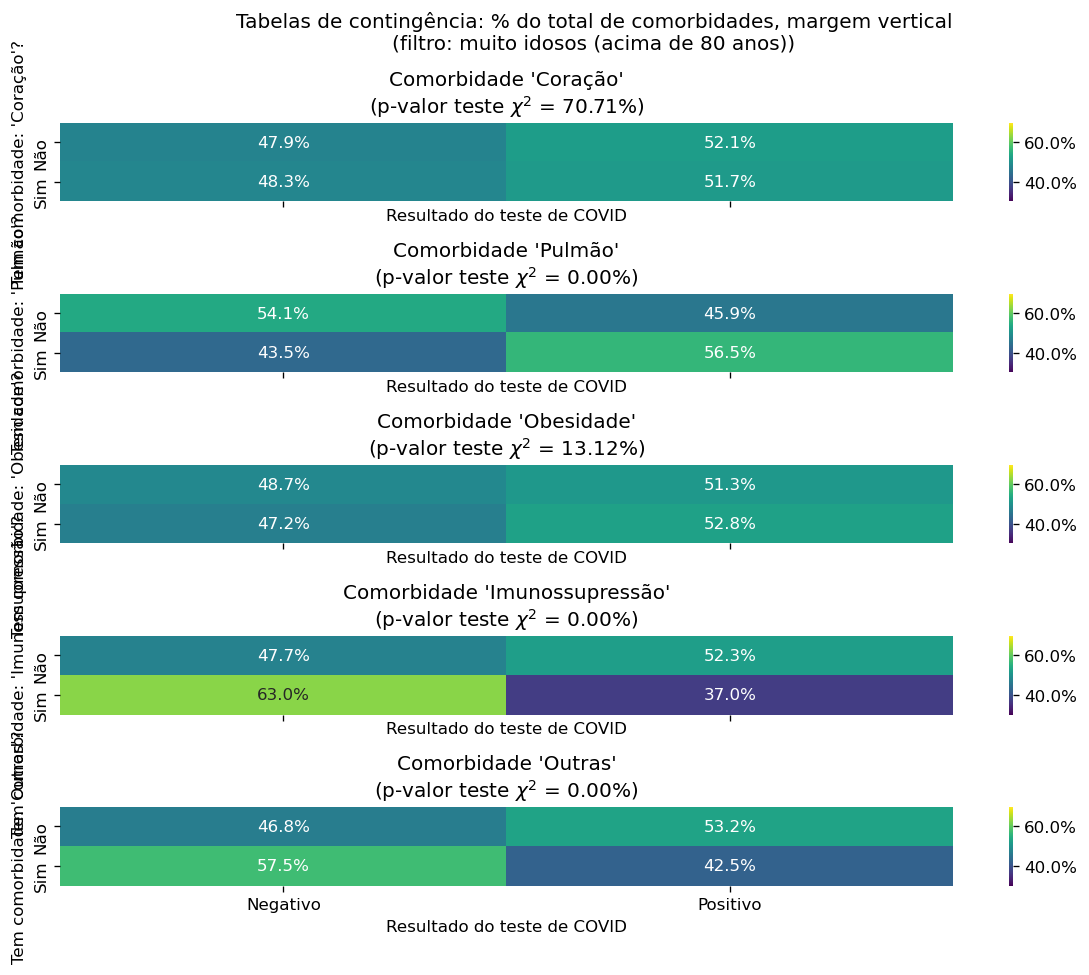

In [31]:
grupos_comorbs = [ grupo['nome'] for grupo in comorbs.values() ]

plot_heatmap_contingencia(
    df = comorbs_df[e_muito_idoso], 
    comorbidades = grupos_comorbs, 
    filtro = 'muito idosos (acima de 80 anos)', 
    teste_quiquad = True,
    cmap_lims = [0.3, 0.7]
);

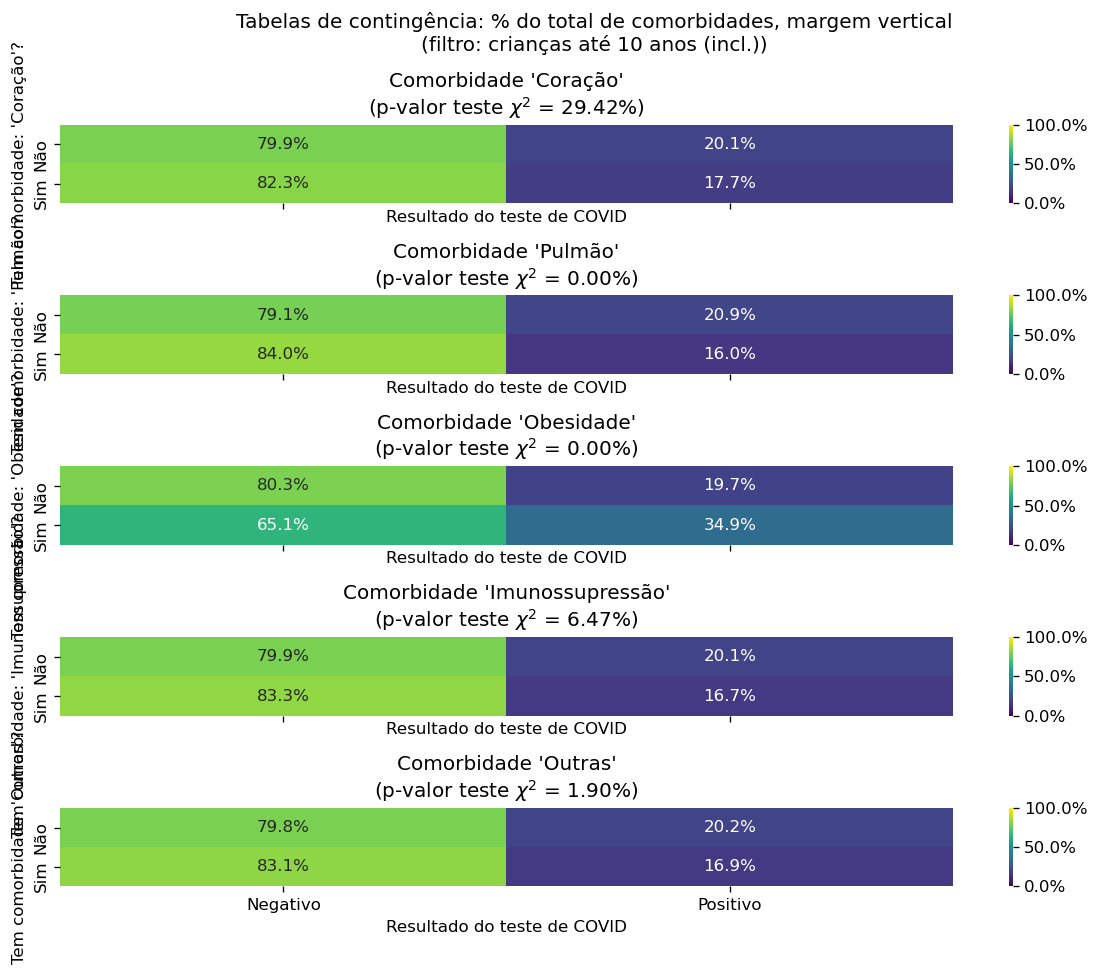

In [32]:
plot_heatmap_contingencia(
    df = comorbs_df[e_crianca], 
    comorbidades = grupos_comorbs, 
    filtro = 'crianças até 10 anos (incl.)', 
    teste_quiquad = True,
);

#### Separando por idade dentro das faixas etárias

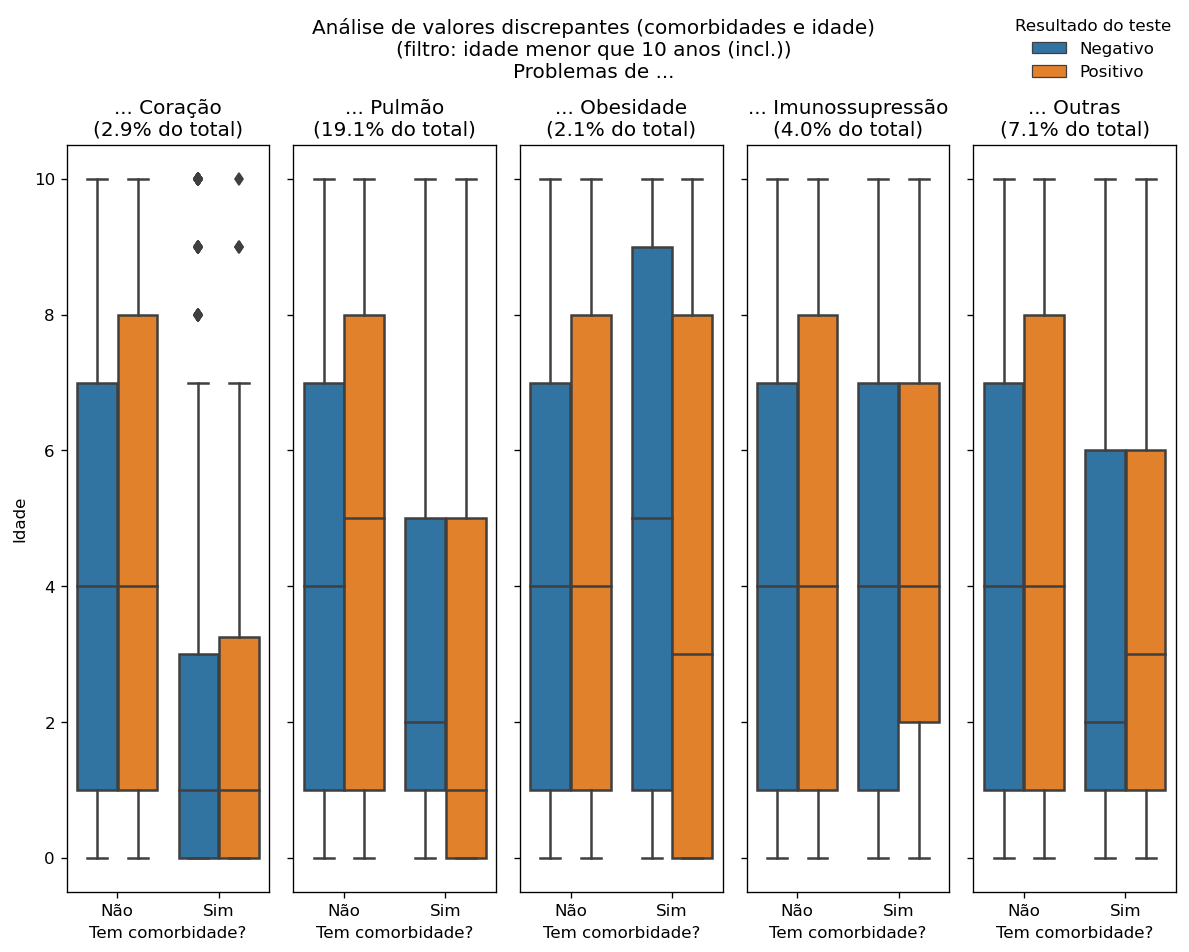

In [33]:
figs['crianca'] = plot_box_comorbs(
    conf_dict = comorbs, 
    data_df = comorbs_df[e_crianca], 
    nome_filtro = 'idade menor que 10 anos (incl.)', 
    eixox = 'comorb'
)

Ressaltamos que, para que uma comorbidade tenha bom poder preditivo, as diferenças entre os resultados positivos e negativos devem ser o mais distante possível de zero.

Do *boxplot* acima, referindo-se somente a crianças abaixo de 10 anos, aprendemos que:

* a lógica do *quanto mais velho fica, mais tem doenças* se inverte. Crianças estão mais vulneráveis a comorbidades, principalmente cardíacas e pulmonares, quando são mais novas.
  * Uma explicação é que o sistema imunológico de crianças mais novas está menos desenvolvido que o de crianças mais velhas.

</br>

* para crianças, as comorbidades mais preditivas de um teste positivo de COVID parecem ser
  * pulmonares;
  * relacionadas à obesidade; e outras.

  Confirma-se portanto a conclusão do teste qui-quadrado.
  
  No entanto, fora as comorbidades pulmonares, há muito poucos dados para outras doenças, de forma que o modelo não deve capturar essa diferença.

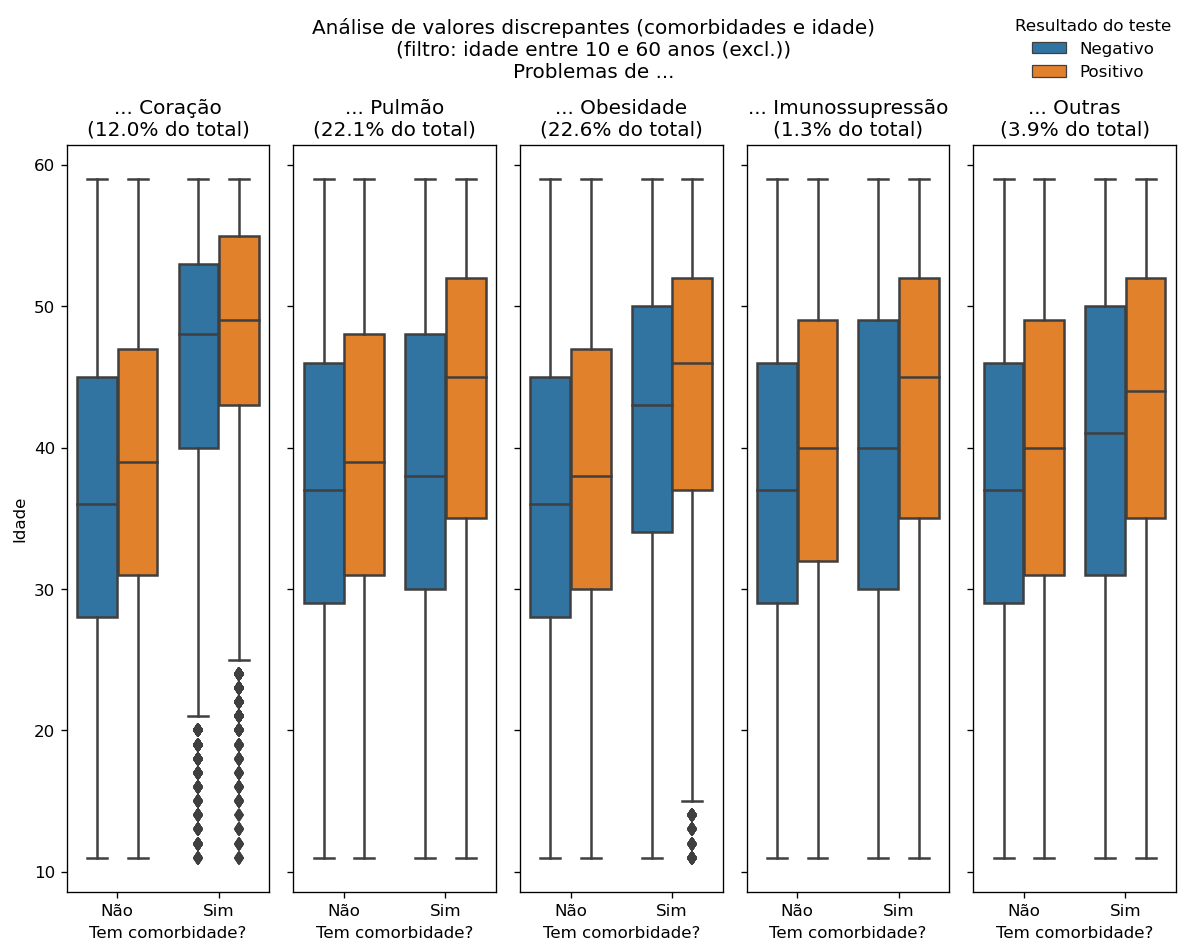

In [34]:
figs['adulto'] = plot_box_comorbs(
    conf_dict = comorbs, 
    data_df = comorbs_df[e_adulto], 
    nome_filtro = 'idade entre 10 e 60 anos (excl.)'
)

Dentro da faixa etária adulta (adolescentes e adultos até 60 anos),

* todas as comorbidades se relacionam com o acometimento por COVID;
* a comorbidade com a maior diferença entre médias de resultados positivos e negativos parece ser a pulmonar. Considerando que também é a mais frequente, é provável que este seja um fator importante no modelo;
* Outra comorbidade com médias de idade diferentes entre resultado positivo e negativo de COVID parece ser a imunossupressão. No entanto, consiste em uma fração muito pequena do total;
* Notamos a grande diferença de idade entre pessoas com ou sem problemas de coração. No entanto, a diferença entre pacientes com resultado positivo e negativo parece ser pequena.

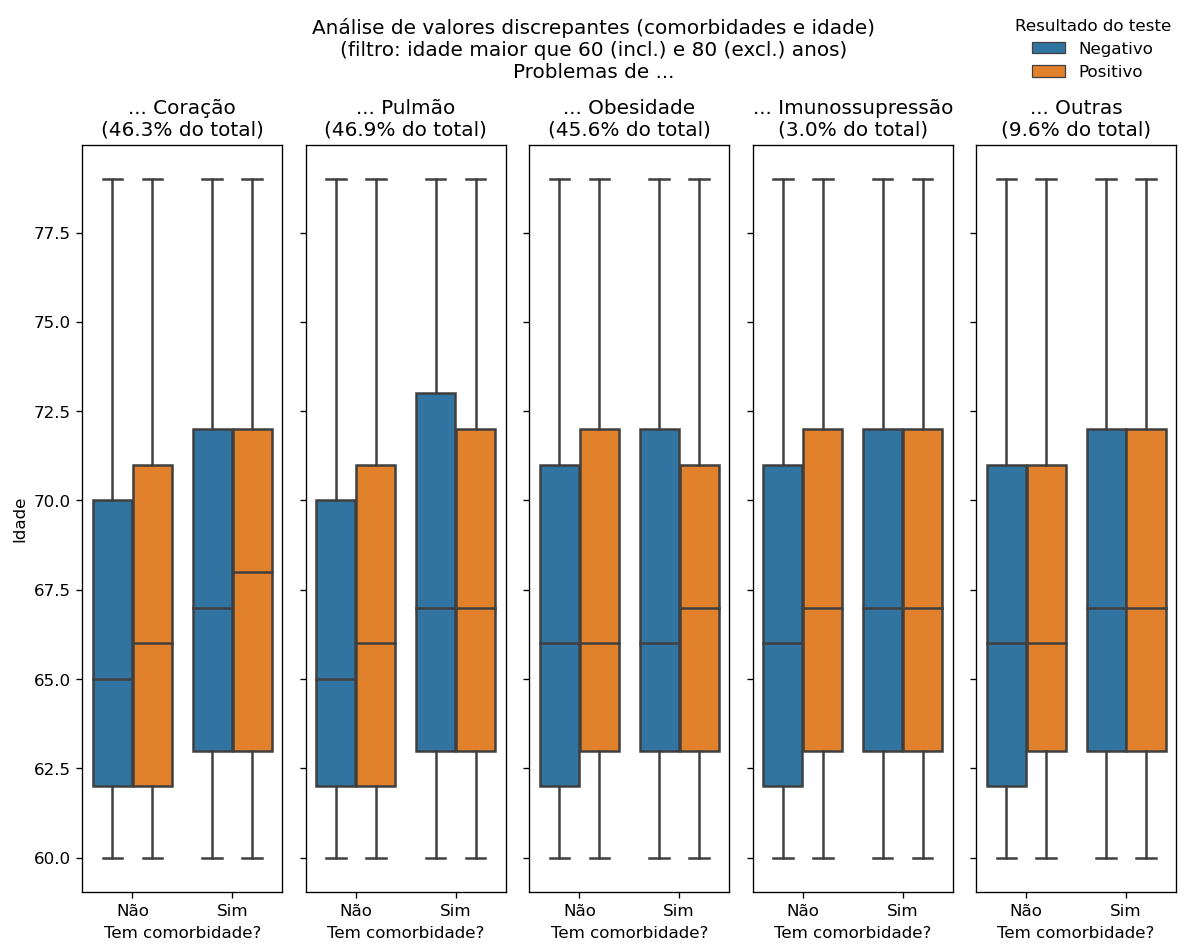

In [35]:
figs['idoso'] = plot_box_comorbs(
    conf_dict = comorbs, 
    data_df = comorbs_df[e_idoso], 
    nome_filtro = 'idade maior que 60 (incl.) e 80 (excl.) anos'
)

Entre os idosos entre 60 e 80 anos:
* Embora o teste qui-quadrado tenha indicado que todas as comorbidades estavam relacionadas com o resultado do teste nesta faixa etária, parte dessa relação parece estar relacionada à idade. Não parece haver muita diferença na distribuição das idades entre resultados positivos e negativos em nenhuma comorbidade.

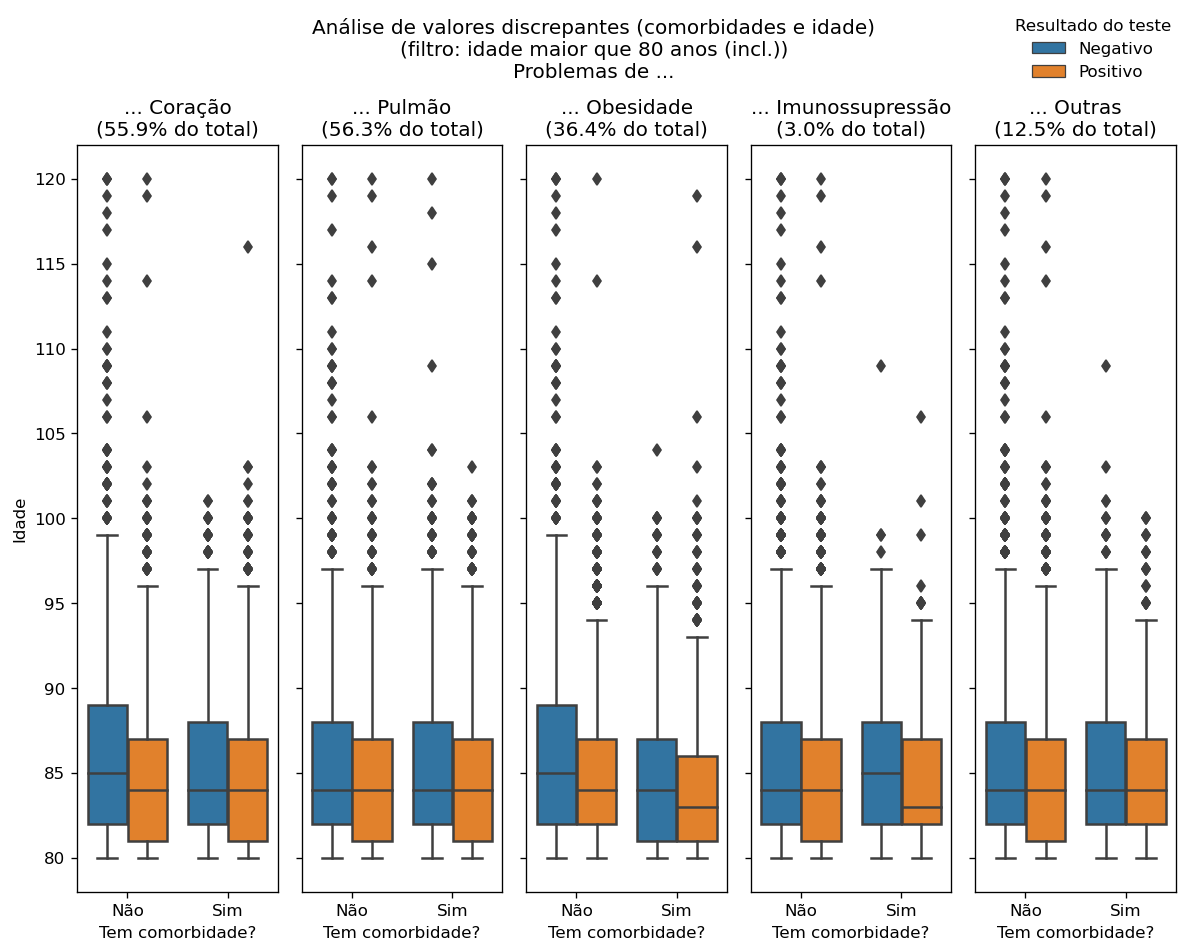

In [36]:
figs['muito_idoso'] = plot_box_comorbs(
    conf_dict = comorbs, 
    data_df = comorbs_df[e_muito_idoso], 
    nome_filtro = 'idade maior que 80 anos (incl.)'
)

Para os muito idosos, acima de 80 anos,
* a distribuição das idades parece ser dominada por pacientes extremamente idosos (acima de 100 anos); e
* como na distribuição de idades das crianças até 10 anos, parece haver uma pequena relação inversa entre presença de comorbidades e idade.

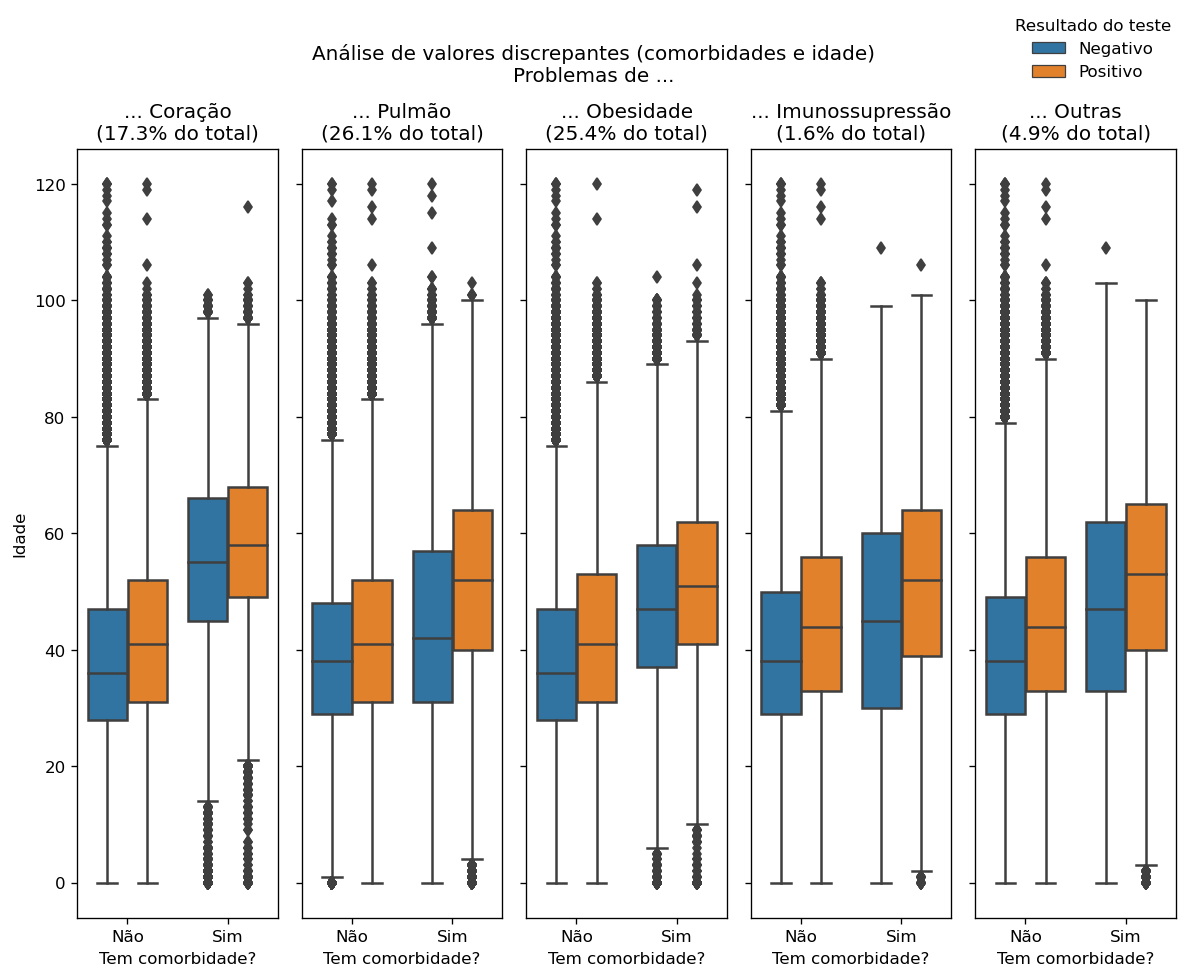

In [37]:
figs['todos'] = plot_box_comorbs(
    conf_dict = comorbs, 
    data_df = comorbs_df
)


Do *boxplot* acima, depreende-se que:

* Como era de se esperar, pacientes mais velhos claramente apresentam comorbidades mais frequentemente, independentemente do resultado do teste;
* **Com a exceção de comorbidades pulmonares e de pacientes imunossuprimidos, a presença ou não de comorbidades parece ser pouco preditiva do resultado do teste**. A diferença entre a distribuição de pacientes com testes positivos e negativos parece se manter constante entre pacientes com ou sem as comorbidades;
* Em pacientes com comorbidades pulmonares e em pacientes imunossuprimidos, a diferença entre as distribuições de pacientes com teste negativo e positivo parece ser mais dispersa que em pacientes sem essa comorbidade.

#### Resumo da análise de comorbidades

* A análise agregada, sem discriminar por faixa etária, mostra que as maiores comorbidades associadas a um teste positivo de COVID são pulmonares ou com pacientes imunossuprimidos. Essa conclusão é reforçada se separarmos por faixa etária.

A análise por faixa etária mostra que

* **Crianças até 10 anos** estão mais vulneráveis ao acometimento por COVID se tem pneumonia ou problemas relacionados à obesidade (excesso de peso ou diabetes);
* **Adolescentes, adultos até 60 anos e idosos entre 60 e 80 anos** estão mais vulneráveis ao contágio se tem qualquer comorbidade no conjunto de dados;
    * No caso dos idosos, essa relação entre as comorbidades e o acometimento por COVID parece estar ligada primariamente à idade;
* **Idosos com mais de 80 anos**: Estão mais vulneráveis ao acometimento por COVID se tem doenças pulmonares, se são imunossuprimidos ou se tem outras doenças.

Notamos também que, 
* com exceção de crianças até 10 anos, **a prática regular do fumo está relacionada ao acometimento por COVID**; e
* em todas as faixas etárias, **a presença de problemas relacionados a obesidade (excesso de peso ou diabetes) está associada ao contágio por COVID**. A exceção são os muito idosos; uma razão para isso é o fato de os obesos não chegarem a idades mais avançadas em números suficientes.
* Tanto entre crianças até 10 anos quanto entre os muito idosos, de mais de 80 anos, parece haver uma relação inversa entre a idade e a presença de comorbidades.

Vamos suprir um outro conjunto de dados com novas features:

In [38]:
comorbs_df

,Coração,Pulmão,Obesidade,Imunossupressão,Outras,age,covid_res
id,,,,,,,
0,False,False,False,False,False,27,1
1,False,False,False,False,False,24,1
2,False,False,True,False,False,54,1
3,False,True,False,False,False,30,1
4,True,False,True,False,False,60,1
...,...,...,...,...,...,...,...
499687,False,True,False,False,True,77,0
499688,True,True,True,False,False,63,0
499689,False,False,False,False,False,25,0


### Contato com outras pessoas comprovadamente com COVID

Vamos agora analisar brevemente a relação entre o campo `contact_other_covid`, que codifica se o paciente teve contato com outras pessoas diagnosticadas com COVID.

#### Relação entre as colunas

Há alguma relação entre esse campo e outros campos relevantes?

In [39]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495062 entries, 0 to 499691
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   sex                  495062 non-null  category
 1   patient_type         495062 non-null  category
 2   pneumonia            495062 non-null  category
 3   age                  495062 non-null  int8    
 4   pregnancy            495062 non-null  category
 5   diabetes             495062 non-null  category
 6   copd                 495062 non-null  category
 7   asthma               495062 non-null  category
 8   inmsupr              495062 non-null  category
 9   hypertension         495062 non-null  category
 10  other_disease        495062 non-null  category
 11  cardiovascular       495062 non-null  category
 12  obesity              495062 non-null  category
 13  renal_chronic        495062 non-null  category
 14  tobacco              495062 non-null  category
 15  

In [40]:
covid['contact_other_covid'].value_counts(normalize = True)

1    0.569408
0    0.430592
Name: contact_other_covid, dtype: float64

In [41]:
cols_relev = ['sex', 'patient_type', 'covid_res']

idx = pd.Index(cols_relev, name = 'campo')

pvalor_contact = pd.Series(index = idx, name = 'pvalor', dtype = float)

for col in cols_relev:
    pvalor_contact[col] = calc_pvalor_quiquad(
        data = covid,
        col = [col, 'contact_other_covid']
    )
    

pvalor_contact


campo
sex             1.509260e-241
patient_type     0.000000e+00
covid_res       1.935278e-290
Name: pvalor, dtype: float64

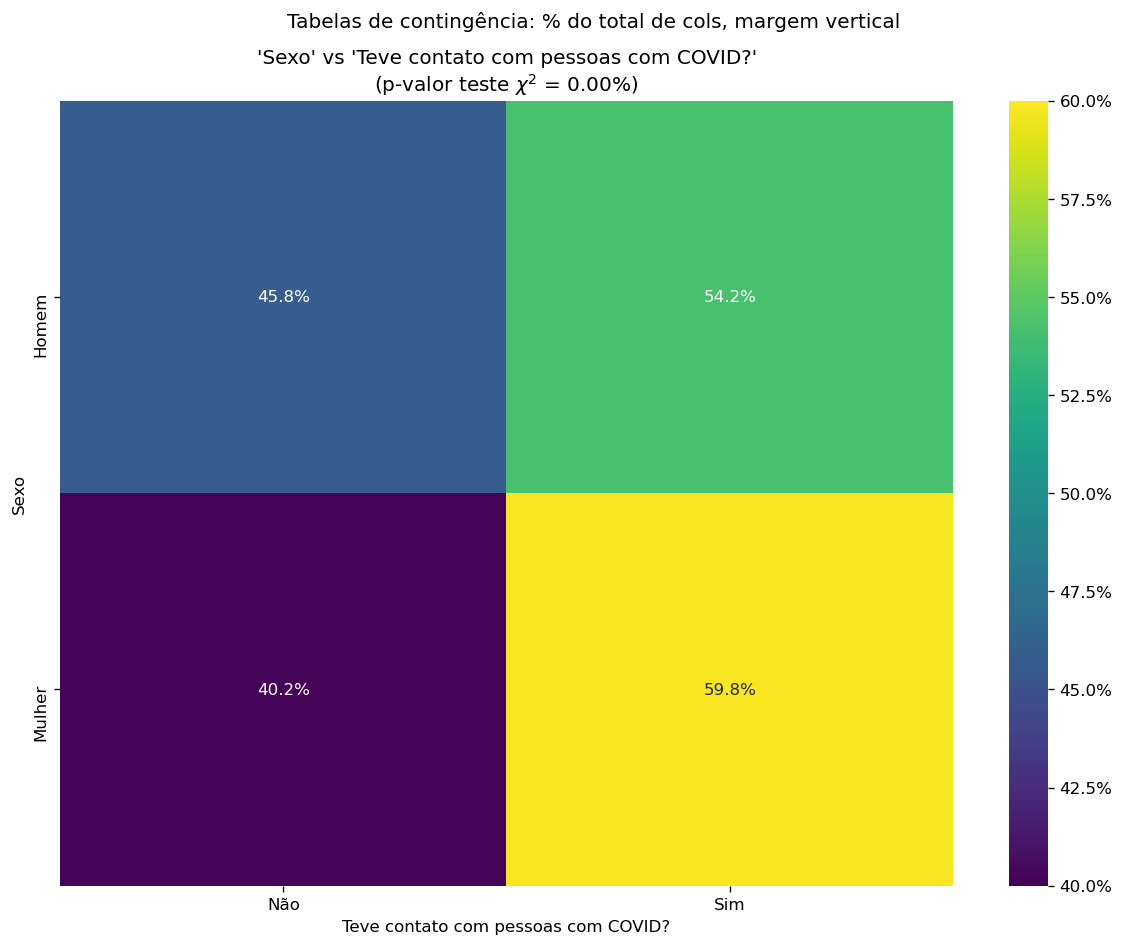

In [42]:
fig = splt.plot_heatmap_chisq(
    data = pd.concat([
        covid['sex'].map({0: 'Homem', 1: 'Mulher'}), 
        covid['contact_other_covid'].map({0: 'Não', 1: 'Sim'}),
    ], axis = 1),
    cols_labels = ['Sexo', 'Teve contato com pessoas com COVID?'],
    chisq = True,
    cmap_lims=[0.4, 0.6]
)

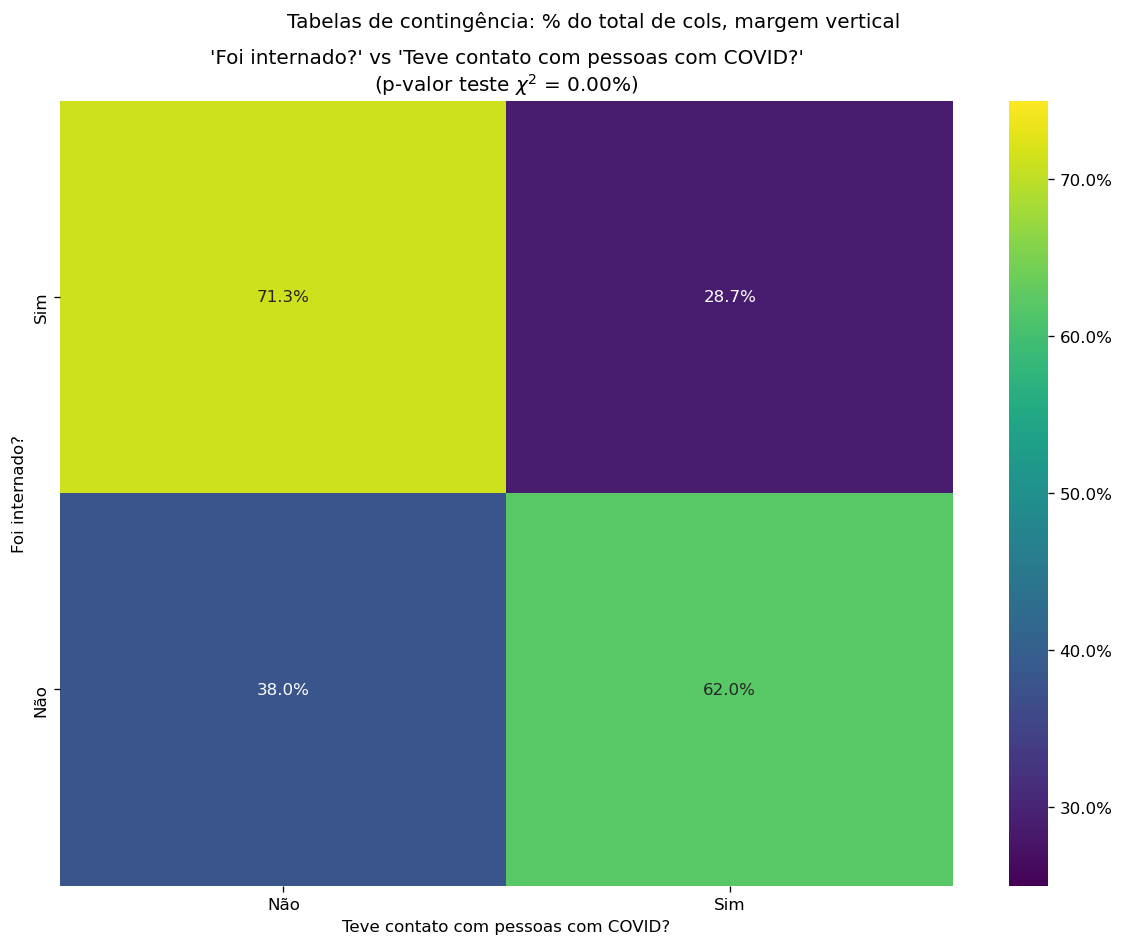

In [43]:
fig = splt.plot_heatmap_chisq(
    data = pd.concat([
        covid['patient_type'].map({0: 'Sim', 1: 'Não'}), 
        covid['contact_other_covid'].map({0: 'Não', 1: 'Sim'}),
    ], axis = 1),
    cols_labels = ['Foi internado?', 'Teve contato com pessoas com COVID?'],
    chisq = True,
    cmap_lims = [0.25, 0.75]
)

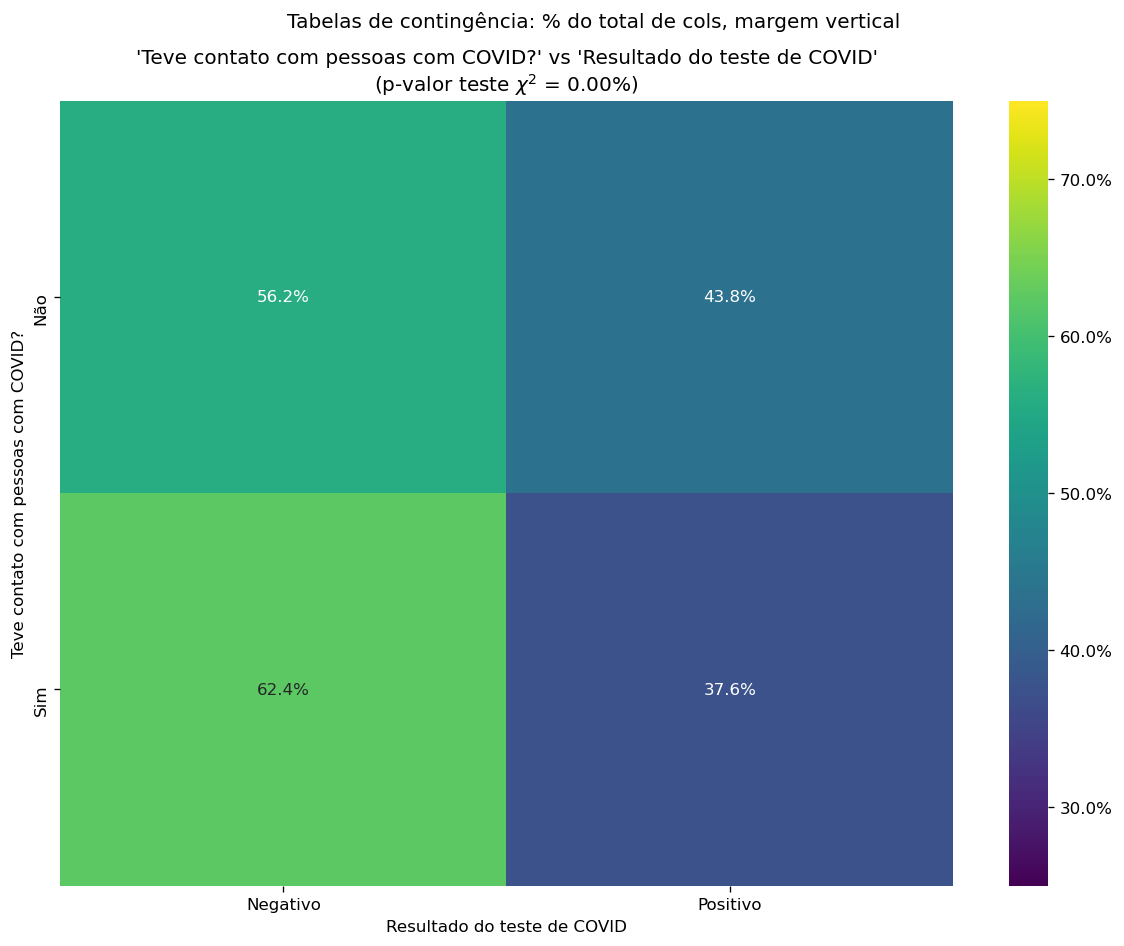

In [44]:
fig = splt.plot_heatmap_chisq(
    data = pd.concat([
        covid['contact_other_covid'].map({0: 'Não', 1: 'Sim'}), 
        covid['covid_res'].map({0: 'Negativo', 1: 'Positivo'}),
    ], axis = 1),
    cols_labels = [ 'Teve contato com pessoas com COVID?', 'Resultado do teste de COVID'],
    chisq = True,
    cmap_lims = [0.25, 0.75]
)

Destes gráficos, depreendemos que as colunas `sex`, `patient_type` e `covid_res` são todas relacionadas de alguma forma à coluna `contact_other_covid`.

#### Análise de dados faltantes

Como sabemos, o campo `contact_other_covid` tem por volta de 30% de dados faltantes:

In [45]:
covid.isna().sum() / covid.shape[0]

sex                    0.000000
patient_type           0.000000
pneumonia              0.000000
age                    0.000000
pregnancy              0.000000
diabetes               0.000000
copd                   0.000000
asthma                 0.000000
inmsupr                0.000000
hypertension           0.000000
other_disease          0.000000
cardiovascular         0.000000
obesity                0.000000
renal_chronic          0.000000
tobacco                0.000000
contact_other_covid    0.307786
covid_res              0.000000
dtype: float64

Há três alternativas para tratamento de dados faltantes do campo `contact_other_covid`:

1. Cortar os registros em que o dado do campo `contact_other_covid` está faltando. É uma fração relevante da base; retirar estes registros enfraqueceria a nossa análise;
2. Manter os registros nulos, codificando-os em uma classe adicional. Este é o caso mais completo, mas há potencial para piora nas métricas de classificação; ou
3. Retirar o campo `contact_other_covid` de análise.

A opção 3 é relativamente ruim, pois vemos que, nos registros em que o campo `contact_other_covid` está preenchido, ele tem uma relação de dependência com o resultado do teste de COVID. Retirá-lo da análise certamente a enfraqueceria.

Por outro lado, vemos que ele também tem uma relação com dois outros campos, `sex` e `patient_type`. A relação com o campo `patient_type` parece especialmente forte. É possível que haja colinearidade entre os dois campos.

No pesar dos prós e contras, não temos muita razão para eliminar nenhuma das três opções. Na falta de razões em prol de uma ou outra, nos resta apenas testar as três e eleger o modelo que apresentar as melhores métricas.

### Análise do campo sexo

In [46]:
covid['sex'].value_counts(normalize = True)

0    0.507217
1    0.492783
Name: sex, dtype: float64

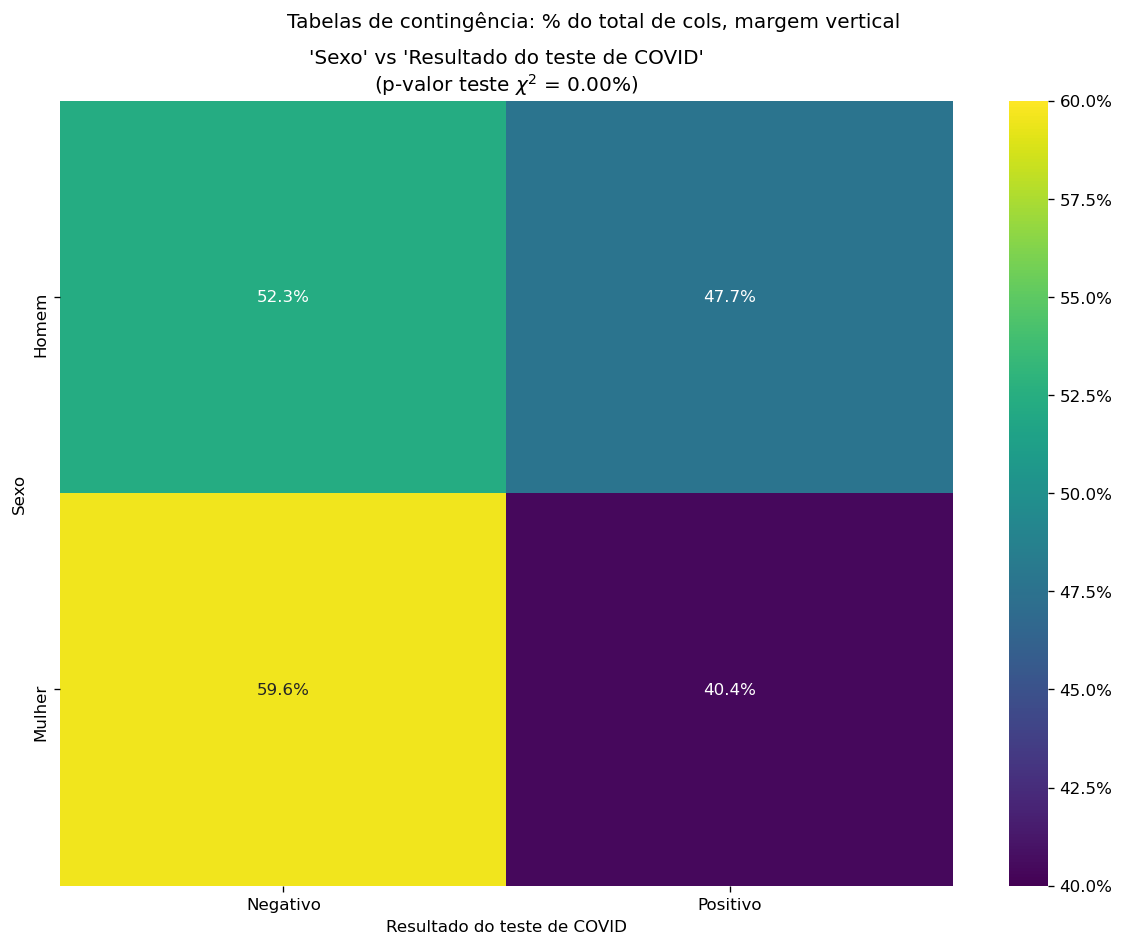

In [47]:
fig = splt.plot_heatmap_chisq(
    data = pd.concat([
        covid['sex'].map({0: 'Homem', 1: 'Mulher'}), 
        covid['covid_res'].map({0: 'Negativo', 1: 'Positivo'}),
    ], axis = 1),
    cols_labels = [ 'Sexo', 'Resultado do teste de COVID'],
    chisq = True,
    cmap_lims = [0.40, 0.60]
)

Deste último gráfico, concluímos que há uma relação de dependência entre o sexo e o resultado do teste de COVID. Claramente, mulheres tem um resultado negativo de COVID mais frequentemente que homens.